In [16]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import sklearn.pipeline
%matplotlib inline


Read in the Data 

In [17]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()





,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
463,11.60,18.36,73.88,412.7,0.08508,0.05855,0.033670,0.017770,0.1516,0.05859,...,12.77,24.02,82.68,495.1,0.1342,0.18080,0.18600,0.08288,0.3210,0.07863
332,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,...,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
455,13.38,30.72,86.34,557.2,0.09245,0.07426,0.028190,0.032640,0.1375,0.06016,...,15.05,41.61,96.69,705.6,0.1172,0.14210,0.07003,0.07763,0.2196,0.07675
263,15.61,19.38,100.00,758.6,0.07840,0.05616,0.042090,0.028470,0.1547,0.05443,...,17.91,31.67,115.90,988.6,0.1084,0.18070,0.22600,0.08568,0.2683,0.06829
167,16.78,18.80,109.30,886.3,0.08865,0.09182,0.084220,0.065760,0.1893,0.05534,...,20.05,26.30,130.70,1260.0,0.1168,0.21190,0.23180,0.14740,0.2810,0.07228


In [18]:
# check for null values 
data.isnull().sum().sum()

0

In [19]:
from sklearn import feature_selection

keep_list = []

# Select which features to keep
for index in range(X.shape[1]):
    if(feature_selection.mutual_info_classif(pd.DataFrame(X.iloc[:,index]),Y) >= 0.07):
       keep_list.append(X.columns[index])

X_reduced = X[keep_list]

print("List of features kept:")
for index in range(len(keep_list)):
    print(index, ") ", '\t',  keep_list[index])

X = X_reduced



List of features kept:
0 )  	 radius_mean
1 )  	 texture_mean
2 )  	 perimeter_mean
3 )  	 area_mean
4 )  	 smoothness_mean
5 )  	 compactness_mean
6 )  	 concavity_mean
7 )  	 concave points_mean
8 )  	 symmetry_mean
9 )  	 radius_se
10 )  	 perimeter_se
11 )  	 area_se
12 )  	 compactness_se
13 )  	 concavity_se
14 )  	 concave points_se
15 )  	 radius_worst
16 )  	 texture_worst
17 )  	 perimeter_worst
18 )  	 area_worst
19 )  	 smoothness_worst
20 )  	 compactness_worst
21 )  	 concavity_worst
22 )  	 concave points_worst
23 )  	 symmetry_worst
24 )  	 fractal_dimension_worst


0.21361649044872902

0.30858580770914606

Best K-Nearest Neighbor: 3.25


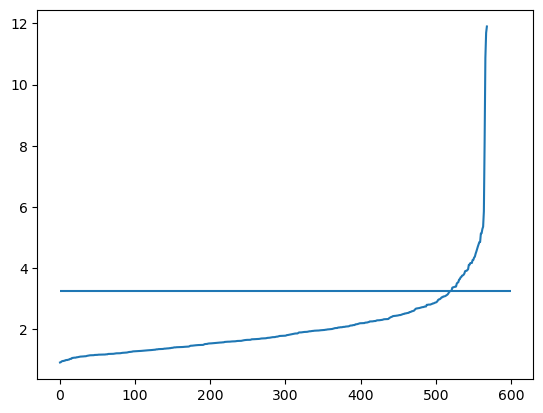

In [20]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
print("Best K-Nearest Neighbor: 3.25")
plt.plot(distances)
plt.hlines(y=3.25, xmin=0, xmax=600)
# best eps around 2.5 for a cutoff on mutual info of .1
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 29


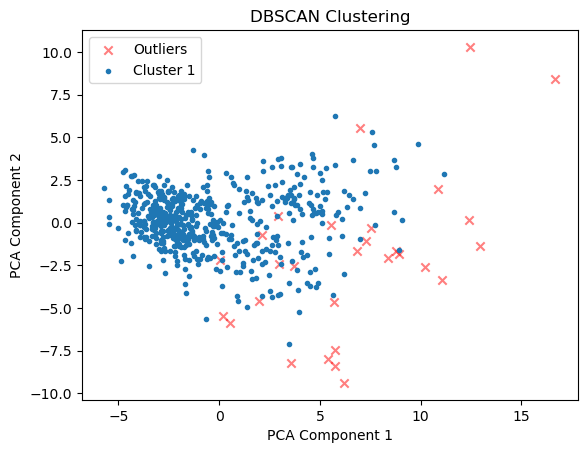

In [21]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3.25, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

inliersX = X.loc[labels == 0]
outliersX = X.loc[labels == -1]

inliersY = Y.loc[labels == 0]
outliersY = Y.loc[labels == -1]


plt.scatter(processed_data.loc[labels == -1, 0], processed_data.loc[labels == -1, 1], 
                    c='red', marker='x', label='Outliers', alpha=0.5)
plt.scatter(processed_data.loc[labels == 0, 0], processed_data.loc[labels == 0, 1], 
                    marker='.', label=f'Cluster 1')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


c:\Users\JoseR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\JoseR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\JoseR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\JoseR\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

K means clustering accuracy when including outliers 0.9209138840070299
K means clustering accuracy when excluding outliers 0.9296296296296296


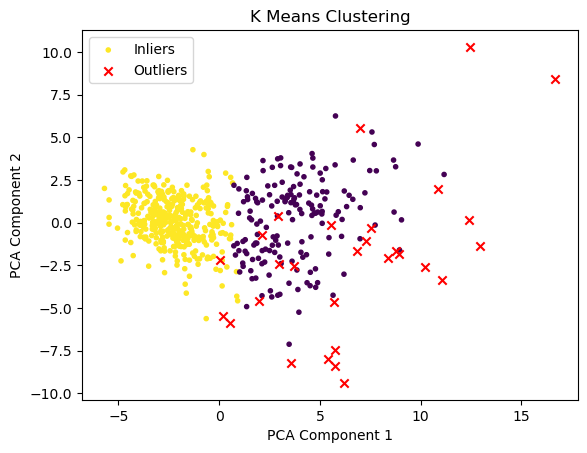

In [22]:
from sklearn.cluster import KMeans




inliers = processed_data[labels == 0]
outliers = processed_data[labels == -1]

# Perform KMeans clustering on the original scaled data
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(processed_data)
klabels_with_outliers = kmeans.labels_
kmeans.fit(inliers)
klabels = kmeans.labels_

k_means_accuracy = max((inliersY == klabels).sum()/(inliersY == klabels).count(), 
                            (inliersY == klabels^1).sum()/(inliersY == klabels^1).count())
k_means_accuracy_wo = max((Y == klabels_with_outliers^1).sum()/(Y == klabels_with_outliers^1).count(),
                            (Y == klabels_with_outliers).sum()/(Y == klabels_with_outliers).count())


print("K means clustering accuracy when including outliers",k_means_accuracy_wo)
print("K means clustering accuracy when excluding outliers",k_means_accuracy)


plt.scatter(inliers.iloc[:,0], inliers.iloc[:,1], c=klabels,marker='.', label='Inliers')
plt.scatter(outliers.iloc[:,0], outliers.iloc[:,1], c='red', marker='x', label='Outliers')
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K Means Clustering')
plt.legend()
plt.show()


In [23]:

X = inliersX
Y = inliersY

# Print statement for metrics at the end

from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("\tAccuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("\tPrecision: ",precision)
    print("\tRecall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [24]:

outputs = []

#Random Forest
print("Testing Random Forest...\n")
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # Hyperparameters
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,3,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration ", i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("\tChosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("\tChosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




Testing Random Forest...

Iteration  0
	Chosen max_depth: 35
	Chosen min_samples_leaf: 1

Iteration  1
	Chosen max_depth: 31
	Chosen min_samples_leaf: 1

Iteration  2
	Chosen max_depth: 32
	Chosen min_samples_leaf: 1

Iteration  3
	Chosen max_depth: 33
	Chosen min_samples_leaf: 1

Iteration  4
	Chosen max_depth: 31
	Chosen min_samples_leaf: 1



In [25]:
#ADA Boosting
print("Testing ADA Boosting...\n")
param_grid = { # Hyperparameters
   'n_estimators': list(range(100,150,10)),
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration", i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("\tChosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



Testing ADA Boosting...

Iteration 0
	Chosen n_estimators: 100

Iteration 1
	Chosen n_estimators: 130

Iteration 2
	Chosen n_estimators: 130

Iteration 3
	Chosen n_estimators: 130

Iteration 4
	Chosen n_estimators: 100



In [26]:
#SVM
print("Testing SVM...\n")
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = { # Hyperparameters
    'pca__n_components': list(range(5, 15)),
    'svc__kernel': ["linear","rbf"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration", i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("\tChosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("\tChosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


Testing SVM...

Iteration 0
	Chosen n_components: 12
	Chosen kernel: linear

Iteration 1
	Chosen n_components: 8
	Chosen kernel: linear

Iteration 2
	Chosen n_components: 9
	Chosen kernel: linear

Iteration 3
	Chosen n_components: 9
	Chosen kernel: linear

Iteration 4
	Chosen n_components: 9
	Chosen kernel: linear



In [27]:
#Nearest Neighbor
print("Testing K-Nearest Neighbors...\n")
param_grid = { # Hyperparameters
    'pca__n_components': list(range(5,10)),
    'knn__n_neighbors': list(range(2,4))
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration",i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("\tChosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("\tChosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



Testing K-Nearest Neighbors...

Iteration 0
	Chosen n_components: 7
	Chosen n_neighbors: 3

Iteration 1
	Chosen n_components: 7
	Chosen n_neighbors: 3

Iteration 2
	Chosen n_components: 9
	Chosen n_neighbors: 3

Iteration 3
	Chosen n_components: 9
	Chosen n_neighbors: 3

Iteration 4
	Chosen n_components: 6
	Chosen n_neighbors: 3



In [28]:
#Simple Neural Net
print("Testing Simple Neural Nets...\n")
from sklearn import neural_network

scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = { # Hyperparameters
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,)],
    "nn__activation": ["tanh",],
    "nn__max_iter" : [200,250,300,350,400]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Iteration", i)
    print("\tChosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("\tChosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("\tChosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



Testing Simple Neural Nets...

Iteration 0
	Chosen hidden_layer_sizes: (60,)
	Chosen activation: tanh
	Chosen max_iter: 300

Iteration 1
	Chosen hidden_layer_sizes: (30,)
	Chosen activation: tanh
	Chosen max_iter: 250

Iteration 2
	Chosen hidden_layer_sizes: (40,)
	Chosen activation: tanh
	Chosen max_iter: 350

Iteration 3
	Chosen hidden_layer_sizes: (60,)
	Chosen activation: tanh
	Chosen max_iter: 350

Iteration 4
	Chosen hidden_layer_sizes: (30,)
	Chosen activation: tanh
	Chosen max_iter: 300



In [29]:
for output in outputs:
    print("Metrics for",output[0])
    print()
    PrintMetrics_list(output[1],output[2])
    print('\n')

Metrics for Random Forest

	Accuracy: 0.9722222222222221


,Predicted 1,Predicted 0
Actual 1,345,5
Actual 0,10,180


	Precision:  0.971830985915493
	Recall: 0.9857142857142858


Metrics for ADA Boosting

	Accuracy: 0.9740740740740741


,Predicted 1,Predicted 0
Actual 1,346,4
Actual 0,10,180


	Precision:  0.9719101123595506
	Recall: 0.9885714285714285


Metrics for SVM

	Accuracy: 0.9796296296296296


,Predicted 1,Predicted 0
Actual 1,348,2
Actual 0,9,181


	Precision:  0.9747899159663865
	Recall: 0.9942857142857143


Metrics for K Nearest Neighbor

	Accuracy: 0.9666666666666666


,Predicted 1,Predicted 0
Actual 1,345,5
Actual 0,13,177


	Precision:  0.9636871508379888
	Recall: 0.9857142857142858


Metrics for Neural Nets

	Accuracy: 0.975925925925926


,Predicted 1,Predicted 0
Actual 1,346,4
Actual 0,9,181


	Precision:  0.9746478873239437
	Recall: 0.9885714285714285


